In [1]:
import tarfile
import time
import matplotlib.pyplot as plt
from data_preprocessing.data_preprocessing import preprocess_tokenize
from input_output.index_io import save_lexicon,save_document_index

In [2]:
def parse_documents_from_tsv(tar_path):
    documents = {}
    with tarfile.open(tar_path, "r:gz") as tar:
        tsv_file = tar.extractfile('collection.tsv')
        if tsv_file:
            content = tsv_file.read().decode('utf-8')
            lines = content.split('\n')
            for line in lines:
                if '\t' in line:
                    doc_id, doc_content = line.split('\t', 1)
                    documents[doc_id] = doc_content
    return documents

In [3]:
def variable_byte_encode(number):
    """Encodes a number using variable byte encoding."""
    if number == 0:
        return [0]

    bytes_list = []
    while number > 0:
        bytes_list.insert(0, number % 128)
        number >>= 7

    # Set the most significant bit to 1 for all but the last byte
    for i in range(len(bytes_list) - 1):
        bytes_list[i] |= 0x80
    bytes_list[-1] |= 0x00  # Ensure the last byte is in the range 0-127

    return bytes_list

In [4]:
def sort_and_merge_postings(postings_lists):
    for term_id, postings in postings_lists.items():
        # Ensure doc_ids are integers
        cleaned_postings = {int(doc_id): freq for doc_id, freq in postings.items()}
        last_doc_id = 0
        encoded_postings = []
        for doc_id, freq in cleaned_postings.items():
            gap = doc_id - last_doc_id
            encoded_gap = variable_byte_encode(gap)
            encoded_freq = variable_byte_encode(freq)
            encoded_postings.extend(encoded_gap)
            encoded_postings.extend(encoded_freq)
            last_doc_id = doc_id

        postings_lists[term_id] = encoded_postings
    return postings_lists


In [5]:
def create_postings_lists(documents, lexicon):
    """
    Updated to use term IDs from the lexicon.
    """
    postings_lists = {}
    for doc_id, document in documents.items():
        for word in document:
            term_id = lexicon.get(word)
            if term_id is not None:
                if term_id not in postings_lists:
                    postings_lists[term_id] = {}
                postings_lists[term_id].setdefault(doc_id, 0)
                postings_lists[term_id][doc_id] += 1
    return postings_lists

In [6]:
def create_lexicon(parsed_documents):
    """
    Create a lexicon mapping terms to unique IDs.

    Args:
    parsed_documents (dict): Parsed documents with document IDs as keys and contents as values.

    Returns:
    dict: A dictionary mapping terms to unique IDs.
    """
    lexicon = {}
    current_id = 0
    for content in parsed_documents.values():
        for word in content:
            if word not in lexicon:
                lexicon[word] = current_id
                current_id += 1
    return lexicon

In [7]:
def save_inverted_index(inverted_index, filename):
    with open(filename, 'wb') as file:
        for term_id, encoded_postings in inverted_index.items():
            # Apply variable byte encoding to the term ID
            file.write(bytes(variable_byte_encode(term_id)))

            # Write the length of the encoded postings list (variable byte encoded)
            postings_length_encoded = variable_byte_encode(len(encoded_postings))
            file.write(bytes(postings_length_encoded))

            # Write the encoded postings list
            file.write(bytes(encoded_postings))

In [19]:
def measure_performance(full_documents, sizes,compiled_re,stemmer,stop_words,punctuation_translator,spell):
    times = []
    last_size = 0
    original_postings_lists = {}  # Original postings lists as dictionaries
    lexicon = {}
    lexicon_sizes = []
    document_index = {}
    
    elapsed_time = 0

    for size in sizes:
        # Select only the new subset of documents
        new_docs = {doc_id: full_documents[doc_id] for doc_id in list(full_documents)[last_size:size]}
        start_time = time.time()

        for doc_id, content in new_docs.items():
            new_docs[doc_id] = preprocess_tokenize(content,compiled_re,stemmer,stop_words,punctuation_translator,spell)
            document_index[doc_id] = len(new_docs[doc_id])

        # Update lexicon and original postings lists with new documents
        new_lexicon = create_lexicon(new_docs)
        for term, id in new_lexicon.items():
            if term not in lexicon:
                lexicon[term] = id
                
        lexicon_sizes.append(len(lexicon))
        new_postings_lists = create_postings_lists(new_docs, lexicon)
        for term_id, new_postings in new_postings_lists.items():
            if term_id not in original_postings_lists:
                original_postings_lists[term_id] = new_postings
            else:
                for doc_id, freq in new_postings.items():
                    if doc_id in original_postings_lists[term_id]:
                        original_postings_lists[term_id][doc_id] += freq
                    else:
                        original_postings_lists[term_id][doc_id] = freq
                        
        # Apply variable byte encoding to the postings lists

        encoded_postings_lists = sort_and_merge_postings({term_id: postings for term_id, postings in original_postings_lists.items()})
        save_inverted_index(encoded_postings_lists, "../data/inverted_index_" + str(size) + ".bin")

        elapsed_time = elapsed_time + time.time() - start_time
        times.append(elapsed_time)
        print(f"Inverted index generation for {size} documents took {elapsed_time:.2f} seconds.")

        last_size = size  # Update last_size for the next iteration
    
    save_lexicon(lexicon,"../data/lexicon.txt")
    save_document_index(document_index,"../data/document_index.txt")
    return times,lexicon_sizes

In [9]:
tar_path = '../data/msmarco/collection.tar.gz'
full_documents = parse_documents_from_tsv(tar_path)

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
compiled_re = re.compile(r'[^a-z0-9\\s]')
punctuation_translator = str.maketrans('', '', string.punctuation)
spell = SpellChecker()

In [20]:
collection_sizes = [1000, 10000,100000,1000000,2000000,4000000,6000000,len(full_documents)]
times,lexicon_sizes = measure_performance(full_documents, collection_sizes,compiled_re,stemmer,stop_words,punctuation_translator,spell)

Inverted index generation for 1000 documents took 0.46 seconds.
Inverted index generation for 10000 documents took 4.78 seconds.
Inverted index generation for 100000 documents took 48.24 seconds.
Inverted index generation for 1000000 documents took 522.40 seconds.
Inverted index generation for 2000000 documents took 1059.29 seconds.
Inverted index generation for 4000000 documents took 2126.63 seconds.
Inverted index generation for 6000000 documents took 3276.16 seconds.
Inverted index generation for 8841823 documents took 4968.33 seconds.


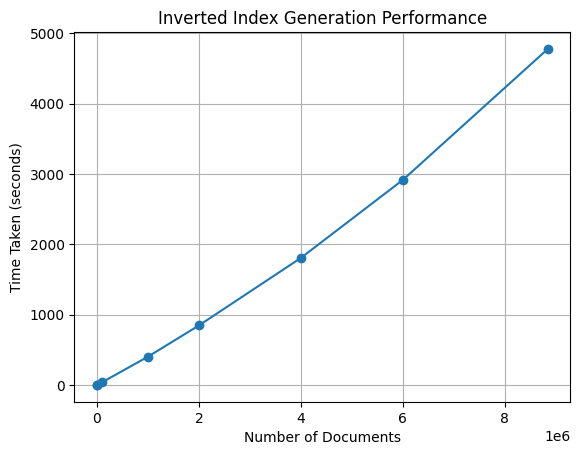

In [ ]:
plt.plot(collection_sizes, times, marker='o')
plt.xlabel('Number of Documents')
plt.ylabel('Time Taken (seconds)')
plt.title('Inverted Index Generation Performance')
plt.grid(True)
plt.show()

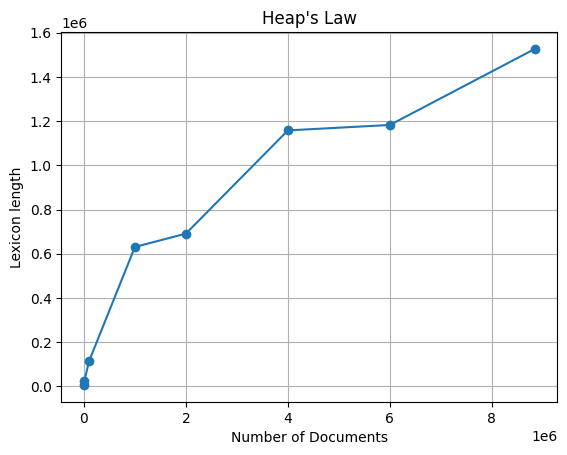

In [ ]:
plt.plot(collection_sizes, lexicon_sizes, marker='o')
plt.xlabel('Number of Documents')
plt.ylabel('Lexicon size')
plt.title('Heap\'s Law')
plt.grid(True)
plt.show()